In [ ]:
#| hide
#| default_exp core
from nbdev import *

# Core

> The core functionality of the HECSS module is provided by the `HECSS` class which encapsulates the `_sampler` generator and exposes `sample` and `generate` as public API.

## `HECSS` class

Standard interface to the HECSS library. This class encapsulates the actual sampler implemented in the `sample` method and provides main functionality of the library through the `generate` method.

In [ ]:
#| exporti
import sys
from fastcore.basics import patch

import numpy as np
from numpy import log, exp, sqrt, linspace, dot
import scipy
from scipy import stats
from scipy.special import expit

from tqdm.auto import tqdm
from itertools import islice
from collections import Counter
from matplotlib import pyplot as plt

import ase
import ase.units as un
from ase.calculators import calculator
from ase.data import chemical_symbols
import spglib
from spglib import find_primitive, get_symmetry_dataset

In [ ]:
#| exporti

_disp_dists = {
    'normal'   : stats.norm,
    'logistic' : stats.logistic,
    'hypsecant': stats.hypsecant,
    'laplace'  : stats.laplace,
    'cauchy'   : stats.cauchy,
}


In [ ]:
#| export
class HECSS:
    '''
    Class encapsulating the sampling and weight generation 
    for the HECSS algorithm.
    
    Create the HECSS sampling object. It is intendet to be a single object 
    per crystal `cryst` used to run samplers for one or more temperatures.
    The object holds data common to all samplers (structure, calculator etc.).
    The other parameters are set per sampler. The set of samplers, indexed 
    by temperature is hold inside the `HECSS` object in the `samplers` dictionary.
    
    #### Arguments
    
    * cryst : crystal structure (ASE `Atoms` object) 
    * calc  : calculator, must be re-usable, otherwise must be calculator generator
    * width : eta, displacement scaling parameter, approx 1.0
    * maxburn : max. number of initial burn-in samples
    * w_search : use width/eta searching algorithm (default True)
    * disp_dist : use different distribution instead of `stats.norm` 
                   as the displacement distribution.
    * directory : basic calculation directory used by directory based calculators
    * pbar : show progress bar during calculations
    
    '''
    
    
    def __init__(self, cryst, calc, width=None, maxburn=20, w_search=True,
                 disp_dist = 'normal', directory=None, pbar=False):
        
        self.cryst = cryst
        self.calc = calc
        self.maxburn = maxburn
        self.w_search = w_search
        self.directory = directory
        self.w_list = []
        self.w_scale = 1e-3 # Overall scale in w(T) function (Ang/sqrt(K))
        self.eta = width # width = eta * w_scale sqrt(T)
        
        self.Q = stats.norm
        try :
            self.Q = _disp_dists[disp_dist]
        except KeyError:
            print(f'Warning: {disp_dist} displacement distribution not supported.\n'
                  'Keeping normal displacement distribution')
            
        self.pbar = None
        self._pbar = None
        if pbar is not None:
            self.pbar = pbar
            
        self.samplers = {}
        
    def smpl_print(self):
        return
        max_r = 15
        if pbar:
            if i==0:
                pbar.set_postfix(Sample='burn-in', n=k, w=w,
                                 dE=f'{(e_star-E_goal)/Es:+6.2f} sigma', 
                                 xs=f'{sqrt(xscale.std()):6.3f}')
            else :
                pbar.set_postfix(xs=f'{sqrt(xscale.std()):6.3f}', config=f'{i:04d}', 
                                 w=w, w_bar=f'{np.mean([_[0] for _ in wl]) if wl else w:7.3f}')
        elif pbar is None :
            if i==0:
                print(f'Burn-in sample {sqrt(xscale.std()):6.3f}:{k}'
                      f'  w:{w:.4f}'
                      f'  dE:{(e_star-E_goal)/Es:+6.2f} sigma', end='\n')
            else :
                print(f'Sample {sqrt(xscale.std()):6.3f}:{n:04d}'
                      f'w:{w:.4f}  <w>:{np.mean([_[0] for _ in wl]) if wl else w:.4f}', end='\n')
            sys.stdout.flush()
        else :
            pass

        
    def print_xs(self, c, s):
        return
        elmap = c.get_atomic_numbers()
        for el in sorted(set(elmap)):
            print(f'{chemical_symbols[el]:2}: {s[elmap==el,:].mean():8.4f}', end='  ')
        print()
        
    

In [ ]:
#| export

@patch 
def estimate_width_scale(self: HECSS, n=1, Tmax=600, set_scale=True, wm_out=False, pbar=None):
    '''
    Estimate coefficient between temperature and displacement scale (eta).
    Calculate energy increase from the `n` temperatures uniformly 
    distributed between 0 and `Tmax` and calculate avarage $\sqrt{E-E0/T}$
    which is a width scale for a given temperature:
    $$
        w = \\eta\\sqrt{T}
    $$
    which comes from the assumed approximate relationship:
    $$
        \\frac{E(w(T))-E_0}{T} \\approx \\mathrm{const} = \\eta^2.
    $$
    
    #### Input
    * `n`    - number of sampling points
    * `Tmax` - max sampled temperature
    * `set_scale` - set scale parameter in the class after run
    * `wm_out` - output additionally array of width vs. sqrt(E)
    * `pbar` - show progress bar during calculation
    
    #### Output
    * if wm_out :  mean(eta), std(eta), wm
    * else : mean(eta), std(eta)
    * wm - the nx3 array of: [width, Temperature, (E-E0)/nat]
    '''

    E0 = self.cryst.get_potential_energy()
    nat = len(self.cryst)
    dim = (nat, 3)    
    
    if self.directory is None :
        basedir = f'calc'
    else :
        basedir = self.directory
        
    cr = ase.Atoms(self.cryst.get_atomic_numbers(), 
                   cell=self.cryst.get_cell(),
                   scaled_positions=self.cryst.get_scaled_positions(),
                   pbc=True, 
                   calculator= self.calc() if callable(self.calc) 
                                           else self.calc)
    close_pbar = False
    
    if self.pbar and pbar is None:
        pbar = tqdm(total=n)
        close_pbar = True
    
    if pbar:
        pbar.reset(n)
        pbar.set_postfix_str('eta estimation')
        if self.w_list:
            pbar.update(len(self.w_list))
        
    while len(self.w_list) < n:
        T = stats.uniform.rvs(0, Tmax) # Kelvin
        if not T:
            continue
        w = self.w_scale * np.sqrt(T)
        dx = self.Q.rvs(size=dim, scale=w)
        cr.set_positions(self.cryst.get_positions()+dx)
        try :
            cr.calc.set(directory=f'{basedir}/w_est/{len(self.w_list):03d}')
        except AttributeError :
            # Calculator is not directory-based
            # Ignore the error
            pass
        E = cr.get_potential_energy()
        self.w_list.append([w, T, (E-E0)/nat])
        if pbar:
            pbar.update()

    wm = np.array(self.w_list).T
    y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
    m = y.mean()
    
    if pbar and close_pbar:
        pbar.close()
    
    if set_scale:
        self.eta = m
        
    if wm_out:
        return m, y.std(), wm
    else :
        return m, y.std()

In [ ]:
#| export
@patch
def _sampler(self: HECSS, T_goal, N=None, delta_sample=0.01, sigma=2,
             eqdelta=0.05, eqsigma=0.2, xi=1, chi=1, xscale_init=None,
             Ep0=None, modify=None, modify_args=None, symprec=1e-5,
             reuse_base=None, verb=True, 
             width_list=None, dofmu_list=None, xscale_list=None):
    '''
    The the core functionality of the module is implemented in this generator function 
    which yields samples of the prior distribution. This is an internal implementation 
    mechanism. In principle, it can be used by outside code but it is **strongly** 
    discouraged as the implementation details may change without any notice 
    (even for minor revisions).
    
    This is a generator and cannot be used as regular function. 
    It is intended to be used as a source of the sequence of 
    configurations in the `for` loop and must be closed after 
    finishing the iteration. On the other hand, the iteration 
    may be continued if additional samples are required. 
    The state is preserved until the .close() method is called.
    The sampling loop may be run for `N` iterations or indefinitely (default).

    
    #### INPUT
    T_goal       : Target temperature in Kelvin
    N            : Number of iterations. If None (default) the generator never stops.
    delta_sample : Prior width adaptation rate. The default is sufficient in most cases.
    sigma        : Range around E0 in sigmas to stop w-serach mode
    eqdelta      : Max. speed of amplitude correction from step to step (0.05=5%)
    eqsigma      : Half width of linear part of amplitude correction function.
    xi           : strength of the amplitude correction term [0-1]
    chi          : strength of the amplitude correction term mixing [0-1]
    xscale_init  : Initial values of the amplitude correction coefficients.
                   Array with shape `cryst.get_positions().shape`.
                   May be generated with `calc_init_xscale` function.
    Ep0          : T=0 energy (base, no displacements), if None (default) calculate E0.
    modify       : pass your own pre-processing function to modify the structure 
                   before calculation. The function must return a  (e, f) tuple
                   with energy of the structure (e, scalar) and forces (f, array).
    modify_args  : dictionary of extra arguments to pass to modify function
    symprec      : symmetry detection treshold for spglib functions
    directory    : (only for VASP calculator) directory for calculations and generated samples. 
                   If left as None, the `calc/{T_goal:.1f}K/` will be used and the generated 
                   samples will be stored in the `smpl/{i:04d}` subdirectories.
    reuse_base   : None or the base calculator created by restarting the ground 
                   state config. If None the base will be recalculated at the start of the run.
                   If the value is a calculator - the energy from this calculator will be used 
                   as ground state energy for the calculation. Be careful to have the same setup 
                   in calc and reuse_base, otherwise the ground state energy and distribution 
                   will be wrong.
    verb         : print verbose progress messages for interactive use
    
    **Output parameters**
    
    width_list   : Output parameter. If not None, store in passed list the sequence of widths.
    dofmu_list   : Output parameter. If not None, store in passed list the array of DOF virials
                   relative to temperature (T_goal).
    xscale_list  : Output parameter. If not None, store in passed list the array of amplitude 
                   correction coefficients (normalized). May be used to generate `xscale_init`
                   values with the help of `calc_init_xscale` function.

    #### OUTPUT
    The generator yields samples from the prior distribution at T_goal temperature 
    as tuples: (number, index, displacement, forces, energy):
    
    - number       : sample number, always increasing
    - index        : integer numbering the samples in the `smpl` subdirectory. 
                     Index repeats if the sample is repeated in the sequence. 
    - displacement : set of atomic displacements (in A) in the sample (numpy array)
    - forces       : set of forces (in eV/A) generated by the displacement
    - energy       : potential energy of the configuration

    '''    
    
    if self._pbar :
        self._pbar.set_postfix_str('Initialization')
        
    nat = len(self.cryst)
    dim = (nat, 3)
    
    symm = get_symmetry_dataset(self.cryst, symprec=symprec)
    dofmap = symm['mapping_to_primitive']
    dof = list(sorted(set(dofmap)))
    dofmu = np.ones((len(dof), 3))
    mu = np.ones(dim)

    if xscale_init is None:
        xscale = np.ones(dim)
    else :
        xscale = np.array(xscale_init)
        assert xscale.shape == dim
    
    # Initialise dofxs from data passed in xscale_init
    dofxs = np.array([xscale[dofmap==d,:].mean(axis=0) for d in dof])
    assert dofxs.shape == dofmu.shape
            
    xi = max(0,xi)
    xi = min(1,xi)

    assert 0 <= xi <= 1 
    
    chi = max(0,chi)
    chi = min(1,chi)

    assert 0 <= chi <= 1 
    
    if Ep0 is None:
        if reuse_base is not None:
            calc0 = reuse_base
            Ep0 = calc0.get_potential_energy()
        else:
            Ep0 = self.cryst.get_potential_energy()
    
    E_goal = 3*T_goal*un.kB/2
    Es = np.sqrt(3/2)*un.kB*T_goal/np.sqrt(nat)   
    
    eta = self.eta
    w = self.eta * self.w_scale * np.sqrt(T_goal) 
    w_prev = w

    if width_list is None :
        wl = []
    else :
        wl = width_list

    Q = self.Q
    P = Q.pdf
    
    i = 0
    n = 0
    
    if self.directory is None :
        basedir = f'calc/T_{T_goal:.1f}K'
    else :
        basedir = f'{self.directory}/T_{T_goal:.1f}K'

    cr = ase.Atoms(self.cryst.get_atomic_numbers(), 
                   cell=self.cryst.get_cell(),
                   scaled_positions=self.cryst.get_scaled_positions(),
                   pbc=True, 
                   calculator= self.calc() if callable(self.calc) else self.calc)
    
    try :
        cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
    except AttributeError :
        # Calculator is not directory-based
        # Ignore the error
        pass

    # Start from the equilibrium position
    e = 0
    x = np.zeros(dim)
    f = np.zeros(dim)
    
    k = 0
    
    if self._pbar:
        self._pbar.set_postfix_str(f'sampling eta={self.eta:.3g}')

    while True:

        # print_xs(cryst, xscale)
        #x_star =  Q.rvs(size=dim, scale=w * w_scale * xscale)
        x_star = xscale * Q.rvs(size=dim, scale=w)

        assert x_star.shape == dim        

        if verb and (n>0 or k>0):
            self.smpl_print()
        
        cr.set_positions(self.cryst.get_positions()+x_star)
        try :
            cr.calc.set(directory=f'{basedir}/smpl/{i:04d}')
        except AttributeError :
            pass

        try :
            if modify is not None:
                e_star, f_star = modify(cr, self.cryst, 's', *modify_args)
            else:
                e_star = cr.get_potential_energy()
                f_star = cr.get_forces()
        except calculator.CalculatorError:
            print(f"Calculator in {cr.calc.directory} faild.\n", file=sys.stderr)
            print("Ignoring. Generating next displacement.", file=sys.stderr)
            continue

        e_star = (e_star-Ep0)/nat
        
        wl.append((w/(self.w_scale*np.sqrt(T_goal)),e_star))

        if i==0 :
            # w-search mode
            delta = 10 * delta_sample
        else :
            # sampling mode
            delta = delta_sample

        w_prev = w

        # Equilibrate all degrees of freedom
        mu = np.abs(f_star*x_star)/(un.kB*T_goal)
        # mu = np.abs(f_star*x_star)/(np.abs(f_star*x_star).mean())
        
        # Avarage mu over images of the atom in the P.U.C.
        dofmu = np.array([mu[dofmap==d,:].mean(axis=0) for d in dof])

        # We use sqrt(mu) since the energy is quadratic in position
        # eqdelta = 0.05 => 5% maximum change in xscale from step to step
        # eqsigma = 0.2 => half width/sharpness of the sigmoid, 
        #                  roughly linear part of the curve
        dofxs *= (1-2*eqdelta*(expit((np.sqrt(dofmu)-1)/eqsigma)-0.5))
        
        # We need to normalize to unchanged energy ~ xs**2
        # The scale must be back linear in xs, thus sqrt(<xs>)
        dofxs /= np.sqrt((dofxs**2).mean())
        
        xscale = (chi * dofxs[dofmap] + xscale * (1 - chi))
        
        # mix with unity: (xi*xs + (1-xi)*1), 0 < xi < 1
        xscale = (xi*xscale + np.ones(dim) - xi) 

        if xscale_list is not None:
            xscale_list.append(np.array(xscale))

        if dofmu_list is not None:
            dofmu_list.append(np.array(dofmu))
        
        if self.w_search :
            w = w*(1-2*delta*(expit((e_star-E_goal)/Es/3)-0.5))
            eta = w/(self.w_scale*np.sqrt(T_goal))
            if i==0 and abs(e_star-E_goal) > sigma*Es :
                # We are in w-search mode but still far from E_goal
                # Continue
                k += 1
                if k>self.maxburn :
                    print(f'\nError: reached maxburn ({maxburn}) without finding target energy.\n'+
                        f'You probably need to change initial width parameter (current:{w})' +
                        f' to a {"higher" if (e_star-E_goal)<0 else "lower"} value.')
                    return
                # Continue searching for proper w
                if self._pbar:
                    self._pbar.set_postfix_str(f'w search: eta={eta:.3g} ({(e_star-E_goal)/(sigma*Es):.2g})')
                continue

        if i==0 :
            # We are in w-search mode and just found a proper w
            # switch to sampling mode by cleaning up after the initial samples
            # clean up the w table
            wl.clear()

        x = x_star
        e = e_star
        f = f_star
        i += 1
        n += 1
        
        if self._pbar:
            self._pbar.set_postfix_str(f'sampling eta={eta:.3g}')
        self.smpl_print()
        if self._pbar:
            self._pbar.update()

        yield n, i-1, x, f, e
        
        if N is not None and n >= N:
            # print('Generator terminated')
            break

In [ ]:
#| export

@patch
def sample(self: HECSS, T, N, sentinel=None, sentinel_args={}, **kwargs):
    '''
    Generate N samples using `HECSS._sampler` generator.
    `sentinel` parameter is a call-back function 
    which is called on every sample to decide if the
    iteration should be stopped early. If it returns
    True the iteration will be stopped and the current 
    list of samples is returned. The sentinel is called
    *after* generating each sample (i.e. first time after 
    first sample is produced). This may take considerable 
    time at the start since first initial and burn-in 
    samples must be produced.
    
    The sampling loop may be run for `N` iterations or indefinitely.

    
    #### INPUT
    * T            : Target temperature in Kelvin
    * N            : Number of iterations.
    * sentinel     :
    * delta_sample : Prior width adaptation rate. The default is sufficient in most cases.
    * sigma        : Range around E0 in sigmas to stop w-serach mode
    * eqdelta      : Max. speed of amplitude correction from step to step (0.05=5%)
    * eqsigma      : Half width of linear part of amplitude correction function.
    * xi           : strength of the amplitude correction term [0-1]
    * chi          : strength of the amplitude correction term mixing [0-1]
    * xscale_init  : Initial values of the amplitude correction coefficients.
                   Array with shape `cryst.get_positions().shape`.
                   May be generated with `calc_init_xscale` function.
    * Ep0          : T=0 energy (base, no displacements), if None (default) calculate E0.
    * modify       : pass your own pre-processing function to modify the structure 
                   before calculation. The function must return a  (e, f) tuple
                   with energy of the structure (e, scalar) and forces (f, array).
    * modify_args  : dictionary of extra arguments to pass to modify function
    * symprec      : symmetry detection treshold for spglib functions
    * directory    : (only for VASP calculator) directory for calculations and generated samples. 
                   If left as None, the `calc/{T_goal:.1f}K/` will be used and the generated 
                   samples will be stored in the `smpl/{i:04d}` subdirectories.
    * reuse_base   : None or the base calculator created by restarting the ground 
                   state config. If None the base will be recalculated at the start of the run.
                   If the value is a calculator - the energy from this calculator will be used 
                   as ground state energy for the calculation. Be careful to have the same setup 
                   in calc and reuse_base, otherwise the ground state energy and distribution 
                   will be wrong.
    * verb         : print verbose progress messages for interactive use
    
    **Output parameters**
    
    * width_list   : Output parameter. If not None, store in passed list the sequence of widths.
    * dofmu_list   : Output parameter. If not None, store in passed list the array of DOF virials
                   relative to temperature (T_goal).
    * xscale_list  : Output parameter. If not None, store in passed list the array of amplitude 
                   correction coefficients (normalized). May be used to generate `xscale_init`
                   values with the help of `calc_init_xscale` function.

    #### OUTPUT
    The returns a list of samples from the prior distribution at T=T_goal as list of tuples
    (number, index, displacement, forces, energy):
    
    - number       : sample number, always increasing
    - index        : integer numbering the samples in the `smpl` subdirectory. 
                     Index repeats if the sample must be repeated in the sequence. 
    - displacement : set of atomic displacements (in A) in the sample (numpy array)
    - forces       : set of forces (in eV/A) generated by the displacement
    - energy       : potential energy of the configuration

    '''    


    # This is a workaround for the miss-design of tqdm 
    # where bool() for total==None returns error 
    # if self.pbar is not None and self.pbar is not False:
    #     self.pbar.reset(N)

    self._pbar = None
    if self.pbar:
        self._pbar = tqdm(total=N)

    if self.eta is None:
        width, sigma = self.estimate_width_scale(2, T, pbar=self._pbar)
        if sigma > width/5 :
            print(f'Warning: low accuracy eta estimation: {width:.2g}±{sigma:.2g}')

    smpls = []
    if self._pbar:
        self._pbar.reset(N)

    if T in self.samplers:
        generator = self.samplers[T]
    else :
        generator = self._sampler(T, **kwargs)
        self.samplers[T] = generator

    for smpl in generator:
        smpls.append(smpl)
        if sentinel is not None and sentinel(smpl, smpls, **sentinel_args):
            break
        if len(smpls) >= N:
            break
    # self.total_N += len(smpls)
    # print(kwargs)
    if self._pbar :
        self._pbar.close()
        self._pbar=None
    return smpls

In [ ]:
#| exporti
from hecss.optimize import make_sampling

In [ ]:
#| export

@patch
def generate(self: HECSS, S, T=None, sigma_scale=1.0, border=False, probTH=0.25, 
                  Nmul=4, N=None, nonzero_w=True, debug=False):
    '''
    Generate new sample with normal energy probability distribution
    corresponding to temperature `T` and size of the system inferred 
    from data. The output is generated by multiplying samples passed in `S`
    proportionally to the wegihts generated by `get_sample_weights`
    and assuming the final dataset will be `Nmul` times longer 
    (or the length `N` which takes precedence). If `nonzero_w` is `True`
    the data multiplyers in the range (probTH, 1) will be clamped to 1,
    to avoid losing low-probability data. This will obviously deform the
    distribution but may be beneficial for the interaction model constructed
    from the data. The data on output will be ordered in increasing energy
    and re-numbered. The configuration index is retained.
    The work is directly delegated to the `make_sampling` function.
    
    #### Input
    * `data`        - list of samples generated by HECSS sampler ([n, i, x, f, e])
    * `T`           - temperature in kelvin, mean energy by default
    * `sigma_scale` - scaling factor for variance. Defaults to 1.0.
    * `border`      - make border samples account for unrepresented part of domain
    * `probTH`      - threshold for probability (N*weight) clamping.
    * `Nmul`        - data multiplication factor. The lenght of output data will be
                      approximately `Nmul*len(data)`.
    * `N`           - approximate output data length. Takes precedence over `Nmul`
    * `nonzero_w`   - prevent zero weights for data with weights in (probTH, 1) range
    * `debug`       - plot diagnostic plots
    
    #### Output
    Weighted, sorted by energy and re-numbered samples as a new list. 
    The data in the list is just reference-duplicated, not copied.
    Thus the data elements should not be modified.
    The format is the same as the data produced by `HECSS` sampler.
    
    '''
    if T is None:
        T = 2*np.mean([s[-1] for s in S])/3/un.kB
    return make_sampling(S, T, sigma_scale=sigma_scale, border=border, probTH=probTH,
                         Nmul=Nmul, N=N, nonzero_w=nonzero_w, debug=debug)    


### The calculator option in sampler

The sampler needs to create a new `Atoms` object for distorted structures and needs a new calculator for this object. Most calculators support re-usage of the calculator object so you can pass just a calculator created for this purpose. Other, notably `asap3.OpenKIMcalculator`, modify the calculator object in-place and make it non-reusable. For such cases you need to pass a generator function in this argument which creates a fresh calculator on each call. The simplest variant is to just use lambda to create the anonymous generator (see examples below). 

```python
sampler = HECSS(SiC, lambda : create_asap_calculator(model))
```

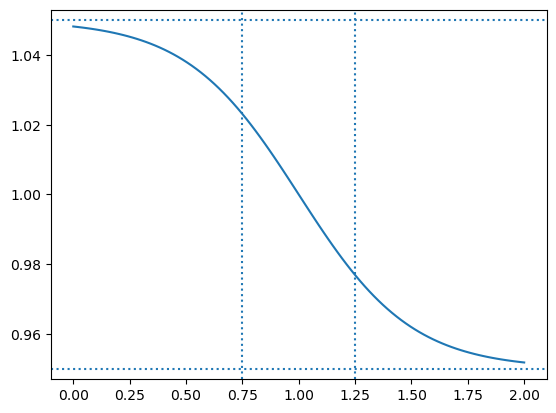

In [ ]:
#| hide 
x = linspace(0, 2, 100)
ampl = 0.05
wdth = 0.25
plt.plot(x, (1-2*ampl*(expit((x-1)/wdth)-0.5)))
plt.axvline(1-wdth, ls=':')
plt.axvline(1+wdth, ls=':')
plt.axhline(1+ampl, ls=':')
plt.axhline(1-ampl, ls=':');

### Examples

#### Cubic Silica Carbide (3C-SiC)

In [ ]:
#| asap

from hecss.monitor import plot_stats, plot_virial_stat, plot_xs_stat, plot_hist
from hecss.monitor import plot_acceptance_history, plot_dofmu_stat
from hecss.util import select_asap_model, create_asap_calculator, calc_init_xscale
from ase.build import bulk
from ase.spacegroup import crystal

In [ ]:
#| asap

model = select_asap_model('SiC')

sys_size = '1x1x1'
sys_size = '2x2x2'
sys_size = '3x3x3'
sys_size = '4x4x4'
sys_size = '5x5x5'

sc = [int(v) for v in sys_size.split('x')]
SiC = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
SiC.set_calculator(create_asap_calculator(model))

In [ ]:
#| asap

sampler = HECSS(SiC, lambda : create_asap_calculator(model), pbar=True)

In [ ]:
#| hide
#| asap

N = 10
T = 300
smpl = sampler.sample(T, N)
smpl += sampler.sample(T, N)
smpl += sampler.sample(T, 20)
assert len(smpl) == (2*N+20)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

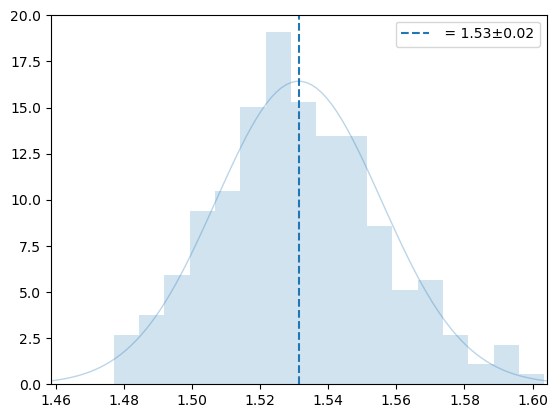

In [ ]:
#| asap
sampler.w_list = []
m, s, wm = sampler.estimate_width_scale(500, Tmax=1000, wm_out=True)
y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plot_hist(y, '', 0)
plt.legend()
plt.show()

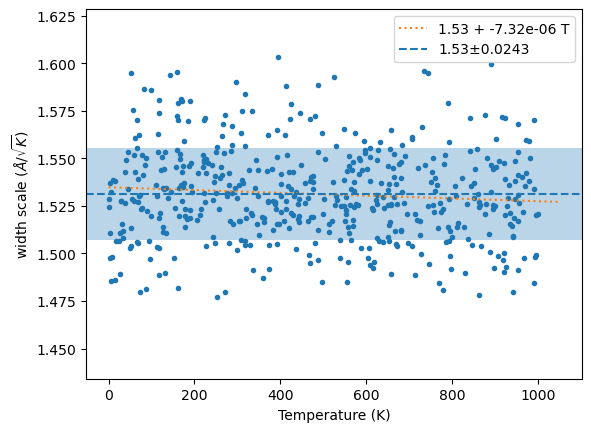

In [ ]:
#| asap
plt.plot(wm[1], y, '.');
x = linspace(0, 1.05*wm[1].max(), 2)
fit = np.polyfit(wm[1], y, 1)
plt.plot(x, np.polyval(fit, x), ':', label=f'{fit[1]:.3g} + {fit[0]:.3g} T')
plt.axhline(m, ls='--', label=f'{m:.3g}±{s:.3g}')
plt.axhspan(m-s, m+s, alpha=0.3)
plt.ylim(m-4*s, m+4*s)
plt.xlabel('Temperature (K)')
plt.ylabel('width scale ($\\AA/\\sqrt{K}$)')
plt.legend();

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

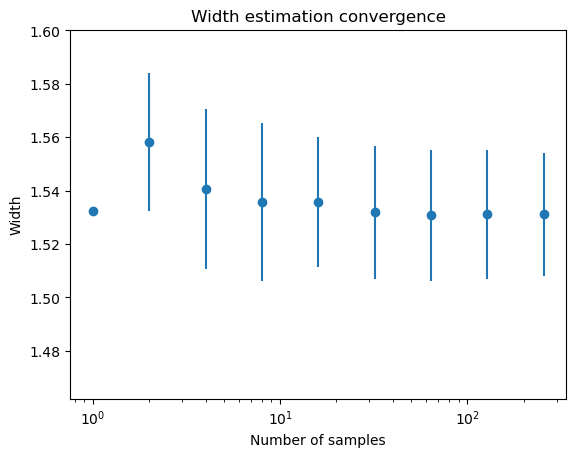

In [ ]:
#| asap
n = 1
sampler.w_list = []
plt.semilogx()
while n < 500 :
    m, s = sampler.estimate_width_scale(int(n), Tmax=1000)
    plt.errorbar(n, m, yerr=s, fmt='o', color='C0')
    n *= 2
plt.ylim(m-3*s,m+3*s)
plt.xlabel('Number of samples')
plt.ylabel('Width')
plt.title('Width estimation convergence');

  0%|          | 0/100 [00:00<?, ?it/s]

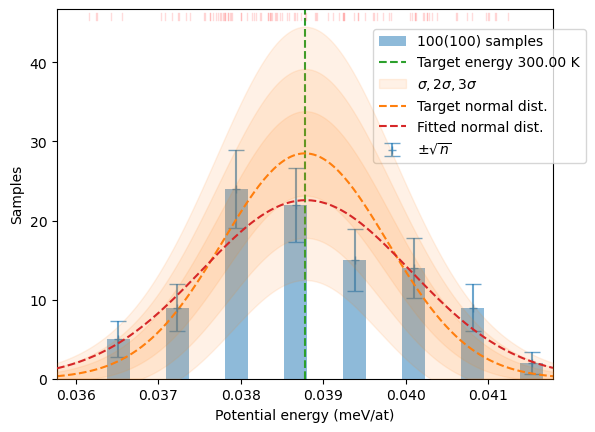

In [ ]:
#| asap
sampler.w_list = []
T = 300
N = 100
samples = sampler.sample(T, N)
plot_stats(samples, T, sqrN=True)

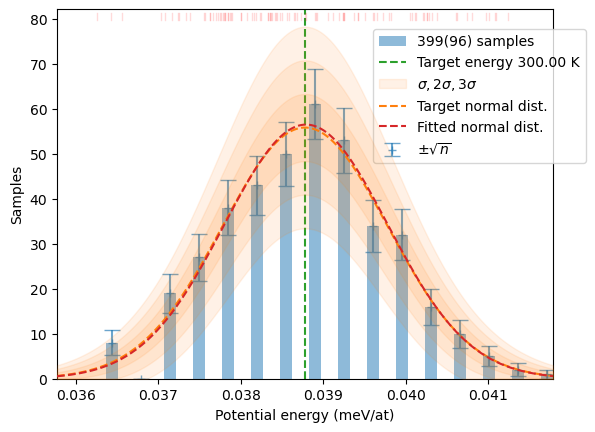

In [ ]:
#| asap
distrib = make_sampling(samples, T, nonzero_w=False, debug=False)
plt.show()
plot_stats(distrib, T, sqrN=True)

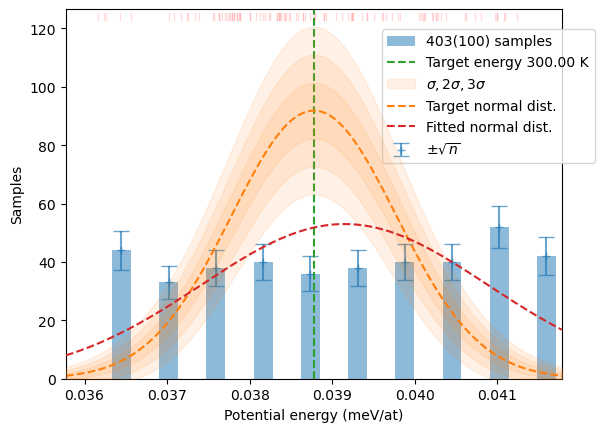

In [ ]:
#| asap
distrib = sampler.generate(samples, T, 3*N)
plot_stats(distrib, T, sqrN=True)

In [ ]:
#| hide
#| asap

N = 1_000
dofmu = []
xsl = []
samples = [s for s in tqdm(sampler._sampler(T, N, 
                                          dofmu_list=dofmu, 
                                          xscale_list=xsl), total=N)]

  0%|          | 0/1000 [00:00<?, ?it/s]

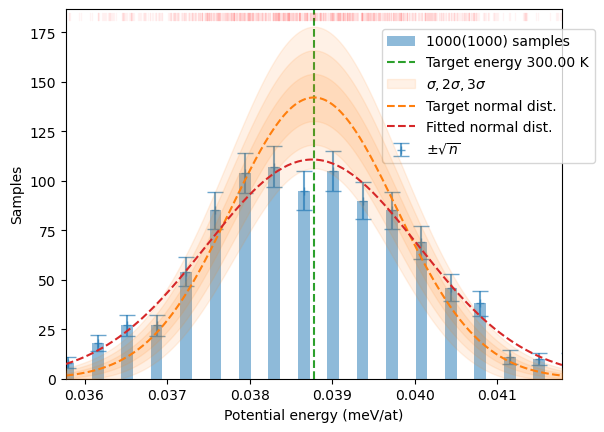

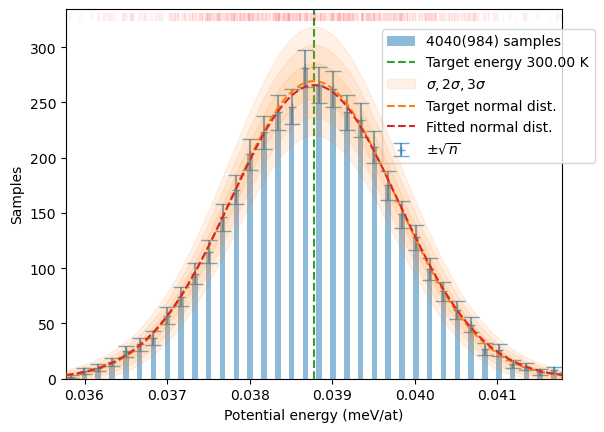

In [ ]:
#| hide
#| asap

plot_stats(samples, T, sqrN=True)
plot_stats(sampler.generate(samples, T), T, sqrN=True)

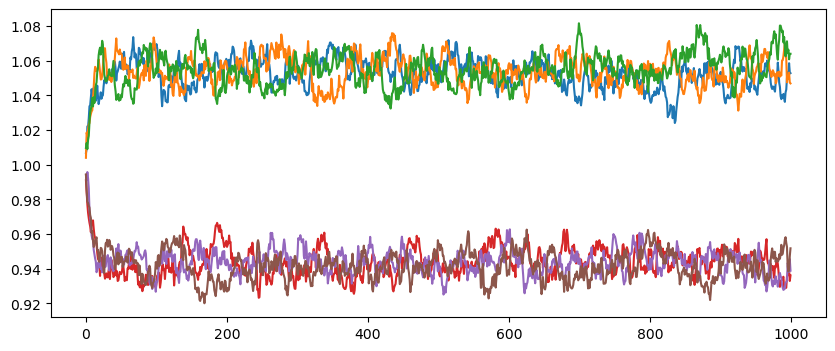

In [ ]:
#| hide
#| asap

plt.figure(figsize=(10,4))
for n, el in enumerate(set(SiC.get_chemical_symbols())):
    elmap = np.array(SiC.get_chemical_symbols()) == el
    plt.plot(np.array(xsl)[:,elmap,:].mean(-2), label=el)
# plt.legend()

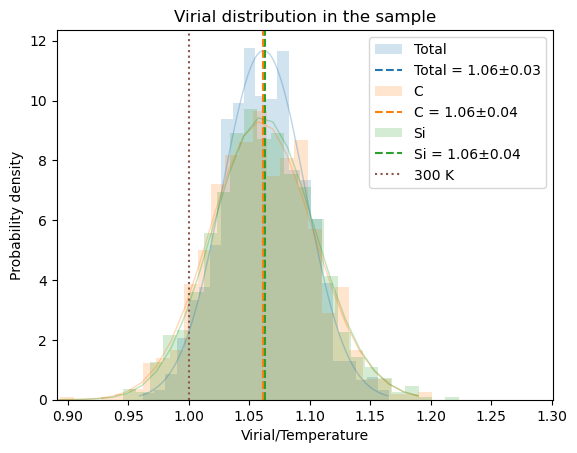

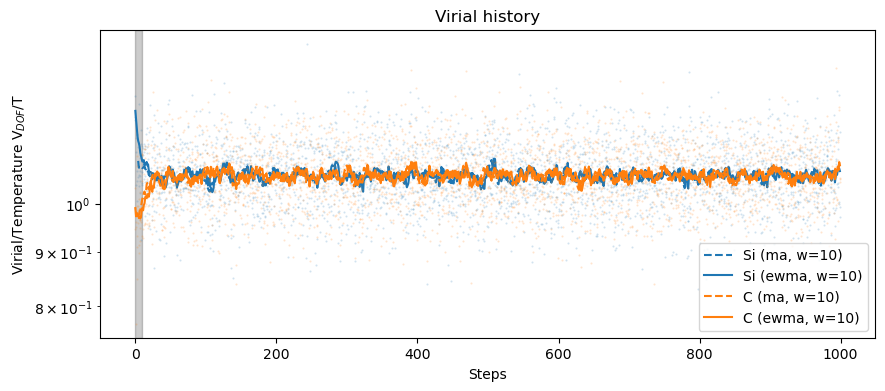

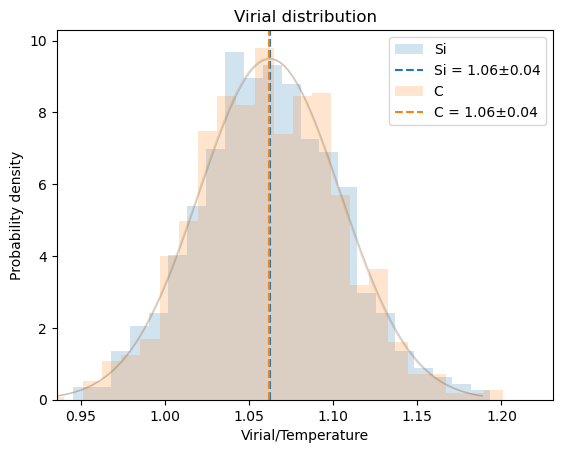

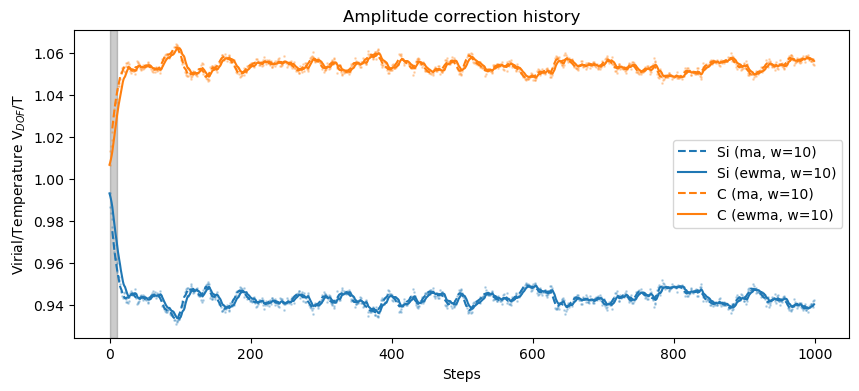

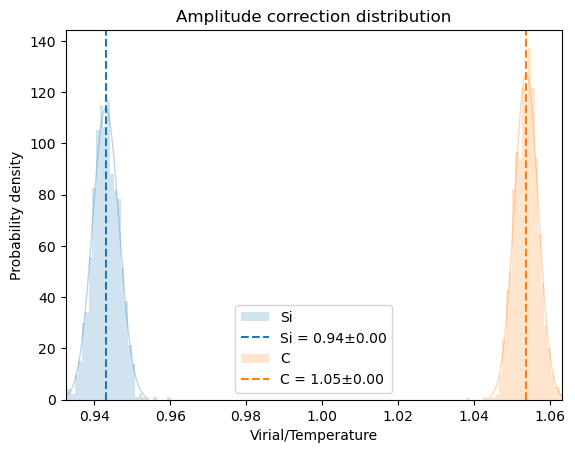

In [ ]:
#| hide
#| asap
plot_virial_stat(SiC, samples, T)
plot_dofmu_stat(SiC, dofmu)
plot_xs_stat(SiC, xsl)

In [ ]:
#| hide
#| asap

m = np.mean([_[-1] for _ in samples])
s = np.std([_[-1] for _ in samples])

s_target = np.sqrt(3/2)*un.kB*T/np.sqrt(len(SiC))

# We should get N samples
assert len(samples) == N

# The mean really should be inside target 2*sigma around T
assert np.abs(m - 3*T*un.kB/2) < 2*s_target

# And sigmas should be within 20% of each other
# assert np.abs(s/s_target - 1)<0.2

#### Olivine in the cubic spinel structure (gamma phase)

In [ ]:
#| asap 

omodel = select_asap_model('Universal')
print(f'Using potential model: {omodel}')

oliv = ase.io.read('data/spinel.POSCAR')
oliv.set_calculator(create_asap_calculator(omodel))
print(f'Space group: {spglib.get_spacegroup(oliv)}')

Using potential model: LJ_ElliottAkerson_2015_Universal__MO_959249795837_003
Space group: Fd-3m (227)


In [ ]:
#| asap 

print(f'Max. stress: {np.abs(oliv.get_stress()[:3]).max()/un.GPa:.3f} GPa')
print(f'Max. force : {np.abs(oliv.get_forces()).max():.3f} eV/A')

Max. stress: 0.881 GPa
Max. force : 0.002 eV/A


In [ ]:
#| asap 

T = 600
dofmu = []
xsl = []
xi = 1
chi = 1
osampler = HECSS(oliv, lambda : create_asap_calculator(omodel))

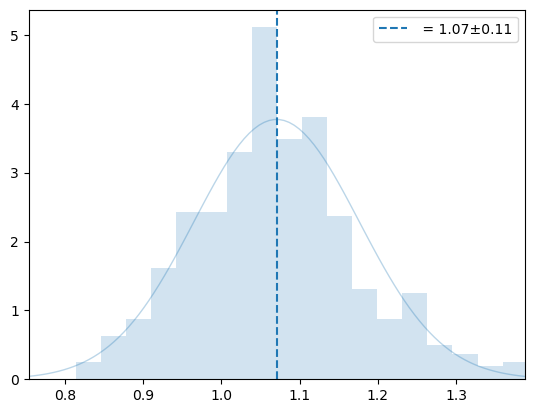

In [ ]:
#| asap
sampler.w_list = []
m, s, wm = osampler.estimate_width_scale(500, Tmax=1000, wm_out=True)
y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plot_hist(y, '', 0)
plt.legend()
plt.show()

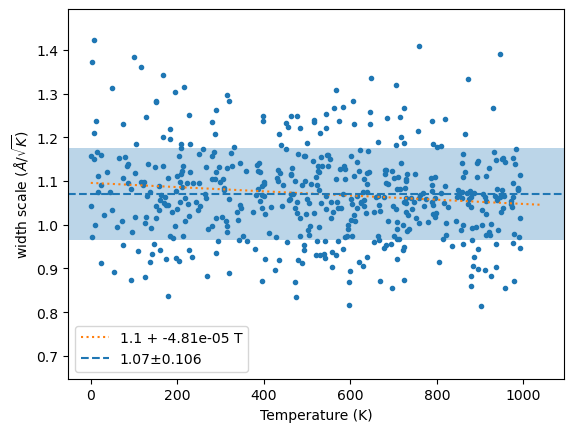

In [ ]:
#| asap
plt.plot(wm[1], y, '.');
x = linspace(0, 1.05*wm[1].max(), 2)
fit = np.polyfit(wm[1], y, 1)
plt.plot(x, np.polyval(fit, x), ':', label=f'{fit[1]:.3g} + {fit[0]:.3g} T')
plt.axhline(m, ls='--', label=f'{m:.3g}±{s:.3g}')
plt.axhspan(m-s, m+s, alpha=0.3)
plt.ylim(m-4*s, m+4*s)
plt.xlabel('Temperature (K)')
plt.ylabel('width scale ($\\AA/\\sqrt{K}$)')
plt.legend();

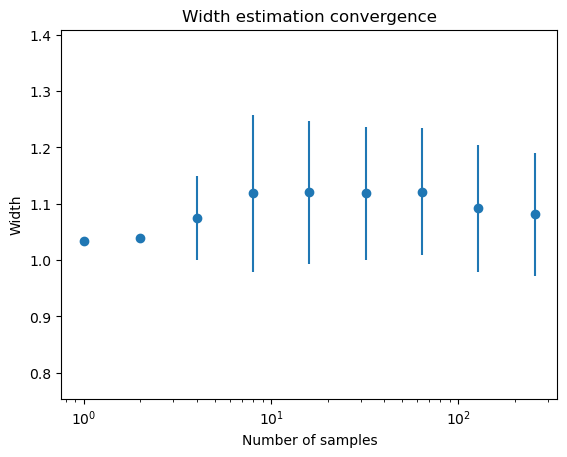

In [ ]:
#| asap
n = 1
osampler.w_list = []
plt.semilogx()
while n < 500 :
    m, s = osampler.estimate_width_scale(int(n), Tmax=1000)
    plt.errorbar(n, m, yerr=s, fmt='o', color='C0')
    n *= 2
plt.ylim(m-3*s,m+3*s)
plt.xlabel('Number of samples')
plt.ylabel('Width')
plt.title('Width estimation convergence');

  0%|          | 0/500 [00:00<?, ?it/s]

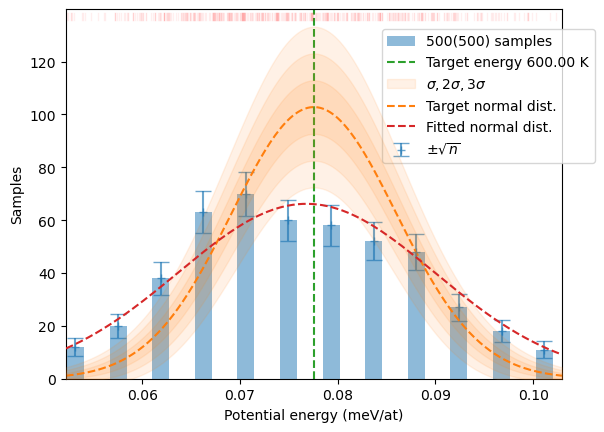

In [ ]:
#| asap
N = 5_00
osamples = [s for s in tqdm(osampler._sampler(T, N, 
                                            dofmu_list=dofmu, xscale_list=xsl), total=N)]
plot_stats(osamples, T, sqrN=True)

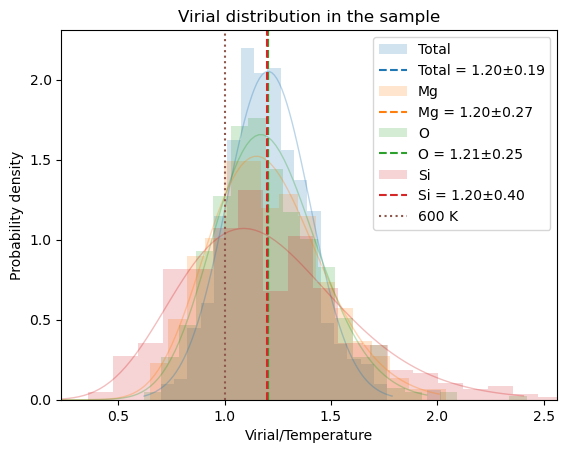

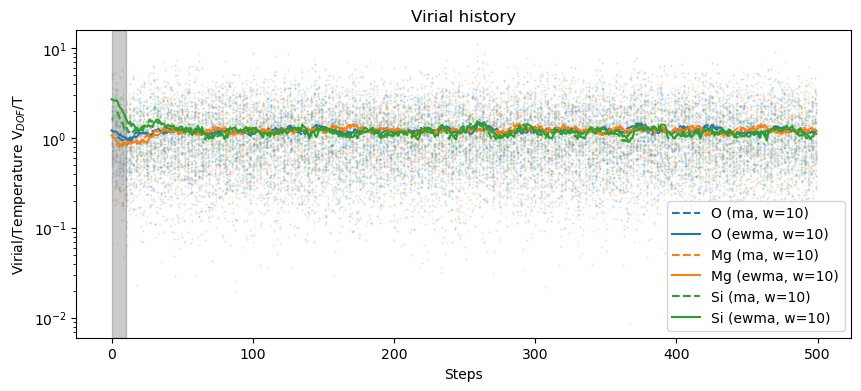

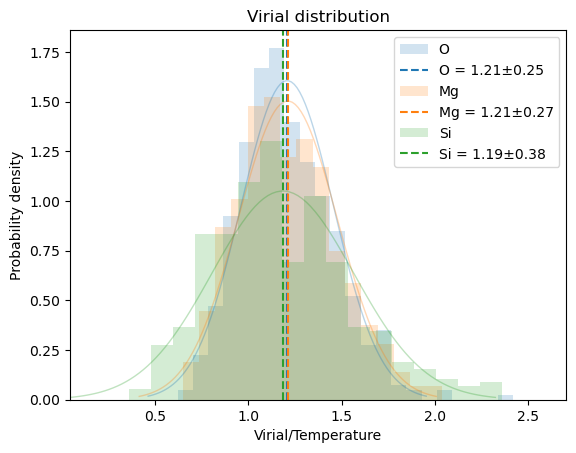

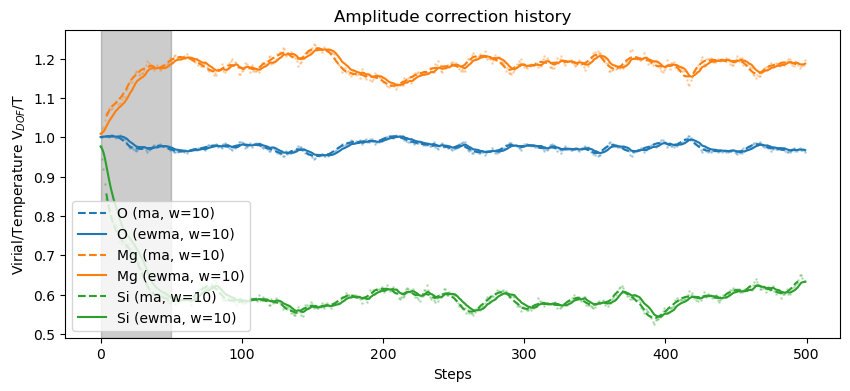

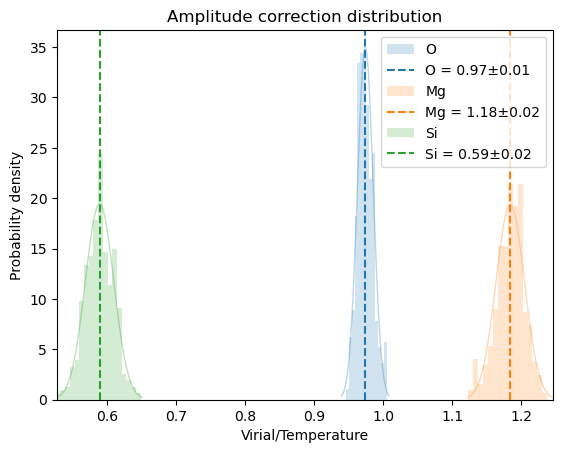

In [ ]:
#| hide
#| asap
    
plot_virial_stat(oliv, osamples, T)
plot_dofmu_stat(oliv, dofmu, skip=10, window=10)
plot_xs_stat(oliv, xsl, skip=50, window=10)

In [ ]:
#| hide
#| asap

m = np.mean([_[-1] for _ in osamples])
s = np.std([_[-1] for _ in osamples])

s_target = np.sqrt(3/2)*un.kB*T/np.sqrt(len(oliv))

# We should get N samples
assert len(osamples) == N

# The mean really should be inside target 2*sigma around T
assert np.abs(m - 3*T*un.kB/2) < 2*s_target

# And sigmas should be within 20% of each other
# assert np.abs(s/s_target - 1)<0.2

#### Continuation of the earlier calculation

In [ ]:
#| hide
#| asap

N = 500
osampler2 = HECSS(oliv, lambda : create_asap_calculator(omodel))
osampler2.eta = osampler.eta
osamples += [s for s in tqdm(osampler2._sampler(T, N, 
                                              xscale_init=calc_init_xscale(oliv, xsl),
                                              dofmu_list=dofmu, 
                                              xscale_list=xsl), total=N)]

  0%|          | 0/500 [00:00<?, ?it/s]

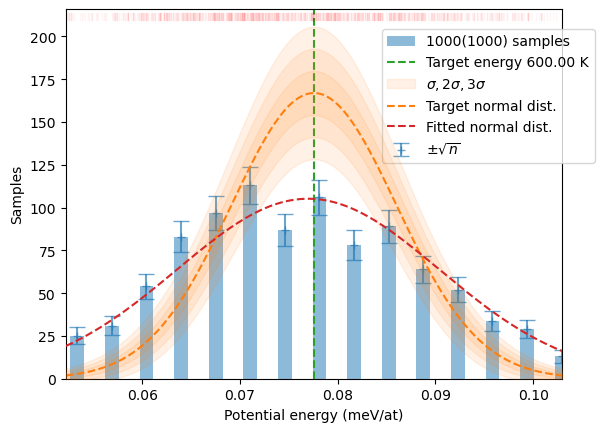

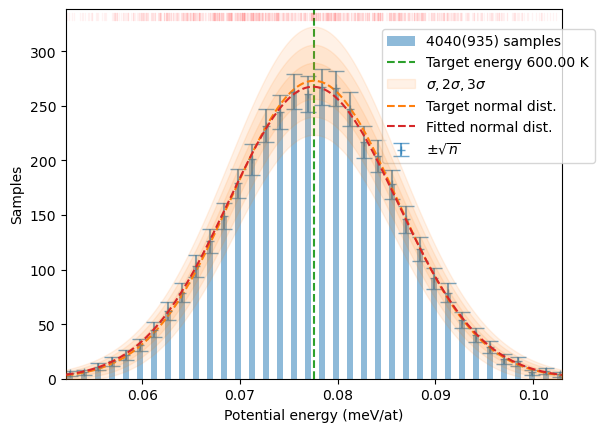

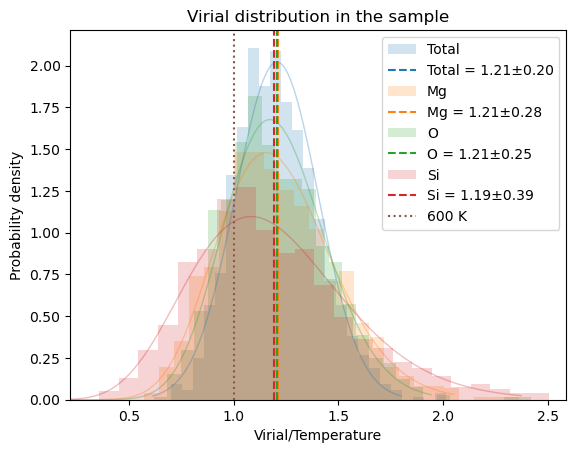

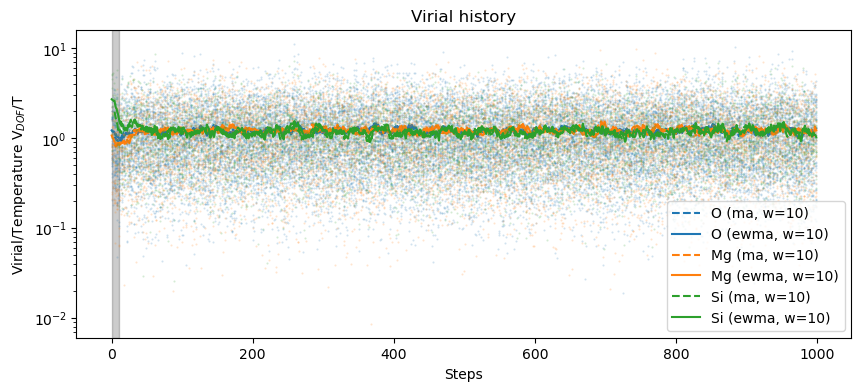

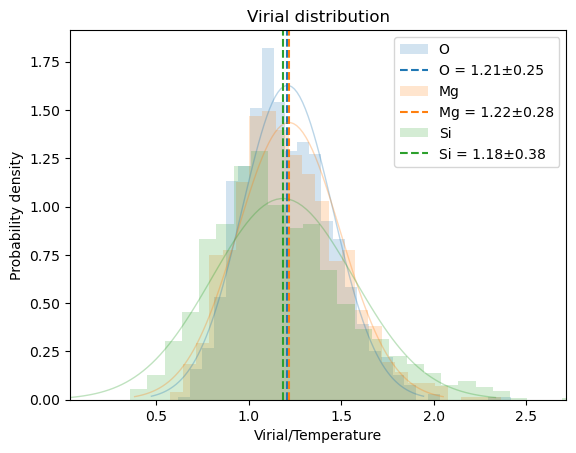

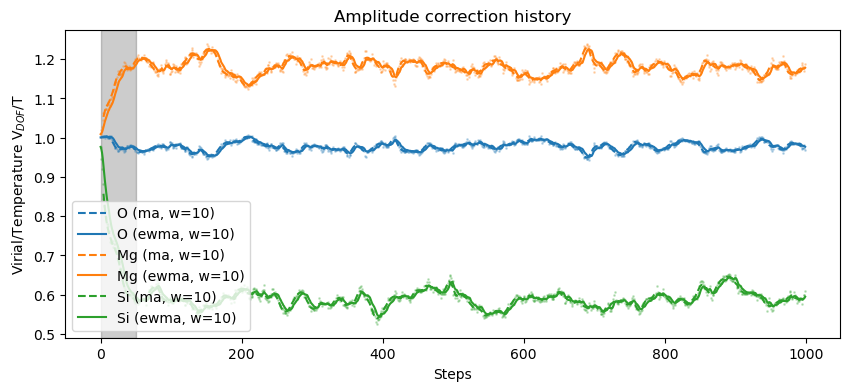

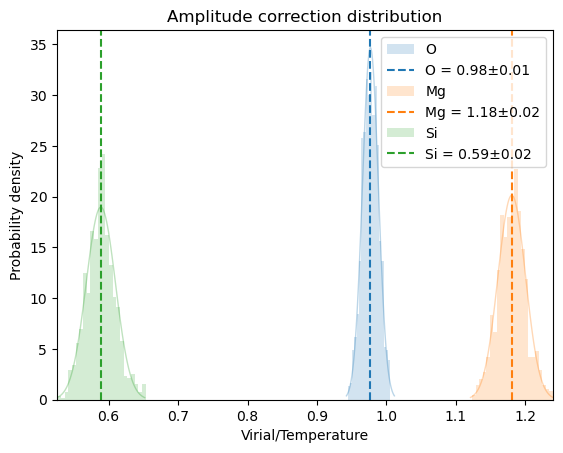

In [ ]:
#| hide
#| asap

plot_stats(osamples, T, sqrN=True)
plot_stats(make_sampling(osamples, T), T, sqrN=True)
plot_virial_stat(oliv, osamples, T)
plot_dofmu_stat(oliv, dofmu)
plot_xs_stat(oliv, xsl, skip=50)